## Imports

In [155]:
import numpy as np
import scipy.signal as signal
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
from scipy.interpolate import make_interp_spline
from scipy.fftpack import dct
import cmath
import matplotlib.pyplot as plt
from scipy.io import wavfile
#import utility
from IPython.display import Audio
import warnings
warnings.filterwarnings("ignore")
import os
import unzip
from zipfile import ZipFile
import random
import parselmouth
import math
import librosa , librosa.display
from tqdm import tqdm
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import shutil

## Utility Functions

In [3]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    
    return torch.device("cpu")

In [4]:
def plot_pitch(pitch):
    pitch_values = pitch.selected_array['frequency']
    # replace unvoiced samples by NaN to not plot
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values,'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values,'o', markersize=4)
    plt.grid(True)
    plt.ylim(0, pitch.ceiling/2)
    plt.ylabel("Pitch in Hz")
    plt.xlabel("time in seconds")

In [5]:
def max_min_pitch(pitch):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    maximum = np.nanmax(pitch_values)
    max_time =  pitch.xs()[np.nanargmax(pitch_values)]
    minimum = np.nanmin(pitch_values)
    min_time =  pitch.xs()[np.nanargmin(pitch_values)]

    return [(maximum,max_time),(minimum,min_time)]

In [6]:
def pre_emphasis(x,alpha=0.6):
    samp = len(x) # The number of samples in x
    y = np.zeros(samp)
    y[0] = x[0]
    for i in range(1,samp):
        y[i] = x[i] - alpha*x[i-1]
    return y

In [7]:
def de_emphasis(x,alpha=0.6):
    samp = len(x) # The number of samples in x
    y = np.zeros(samp)
    y[0] = x[0]
    for i in range(1,samp):
        y[i] = x[i] + alpha*y[i-1]
    return y

In [8]:
def framing(emphasized_signal,sample_rate,frame_size=0.025,frame_stride=0.01):
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    return frames,frame_length

In [9]:
def windowing(frames,frame_length):
    windowed_frames = frames*np.hamming(frame_length)

    return windowed_frames

In [10]:
def fft_and_pow_spectrum(windowed_frames,NFFT=512):
    frames = windowed_frames
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    return pow_frames

In [11]:
def mel_filter_bank(pow_frames,sample_rate,nfilt=40,NFFT=512):
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8) # Mean Normalization to balance the spectrum and improve the Signal-to-Noise (SNR)

    return filter_banks

In [12]:
def mfcc(filter_banks,num_ceps=12):
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    #cep_lifter???
    #(nframes, ncoeff) = mfcc.shape
    #n = numpy.arange(ncoeff)
    #lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
    #mfcc *= lift  #*
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8) # Mean Normalization to balance the spectrum and improve the Signal-to-Noise (SNR)

    return mfcc

In [65]:
# Function to add 10dB SNR noise to a speech utterance.
# Description = Clips a segment of noise from a random position from the noise file.
# The noise segment is normalized and added to the speech. The noisy speech is saved to a separate file.
# Inputs:
# speechfile = Path to the speech utterance .wav file
# noisefile = Path to the noise .wav file
# outputfile = Path (along with a .wav file name) where the noisy speech file must be saved
def add_noise(speechfile, noisefile, outputfile):

    #reading the .wav files
    sampFreq, noise = wavfile.read(noisefile)
    sampFreq, speech = wavfile.read(speechfile)
    numSamples = len(speech)
    #clipping a segment of noise from a random position, with segment length equal to the length of speech
    i = np.random.choice(np.arange(len(noise) - numSamples))
    noise = noise[i:i+numSamples]
    #converting the PCM values to floats with range from -1.0 to 1.0
    speech = speech/32768
    noise = noise/32768
    #normalizing the noise and adding it to the speech
    rawEnergy = np.sum(speech**2)
    noise = noise*(np.sqrt(rawEnergy/(10*np.sum(noise**2))))
    speech = speech + noise
    #normalizing the noisy speech so that its energy equals the energy of raw speech
    speech = speech*(np.sqrt(rawEnergy/np.sum(speech**2)))
    #converting the floats back to PCM values
    speech = speech*32767
    speech = speech.astype(np.int16)
    #saving the noisy speech to the output file
    wavfile.write(outputfile, sampFreq, speech)

    return

## Reading the files

In [13]:
#Unzipping the command folders
train_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands Dataset\train'
for command in os.listdir(train_folder):
    command_folder = os.path.join(train_folder,command)
    with ZipFile(command_folder, 'r') as zObject: 
        # Extracting all the members of the zip  
        # into a specific location. 
        zObject.extractall(path=r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train')    

In [14]:
#Extracted folders
train_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train'
commands = []
for command in os.listdir(train_folder):
    command_folder = os.path.join(train_folder,command)
    command = []
    for filename in os.listdir(command_folder):
        file = os.path.join(command_folder,filename)
        f_samp, sig = wavfile.read(file)
        #print("The number of samples = ",len(sig))
        sig = sig.astype(float)
        dur = len(sig)/f_samp
        #print("The sampling frequency of the signal is = ",f_samp, "Hz")
        #print("The duration of the signal is:",dur, "seconds")
        command.append([f_samp,sig,dur])
    commands.append(command)

In [15]:
f_samp = commands[3][0][0] # [command][speaker][pos in tuple]
sig = commands[3][0][1]
dur = commands[3][0][2]
print(commands[3][0])
print(dur)

[16000, array([236., 200., 181., ..., 321., 279., 302.]), 1.0]
1.0


In [16]:
Audio(sig,rate=f_samp)

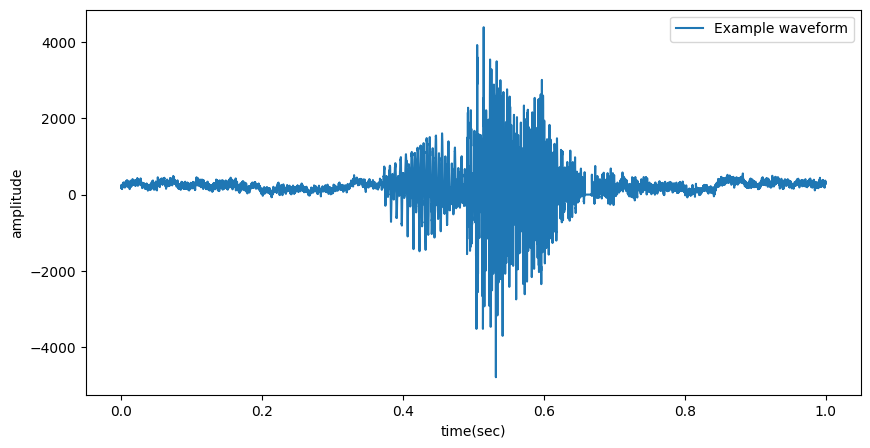

In [17]:
plt.figure(figsize=(10,5))
t = np.linspace(0,dur,len(sig))
plt.plot(t,sig,label="Example waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
plt.show()

## Speech End-pointing
---
1. Method 1: Amplitude-based. We will only keep samples which have an amplitude greater than 0.25% of the maximum amplitude of the signal and assume that the rest is silence.
2. Method 2: Speech Activity Detection (SAD)

### 1. Amplitude/Energy based

In [18]:
commands_cropped = []
commands_voiced_ind = []
for command in commands:
    #print(command)
    command_cropped = []
    command_voiced_ind = []
    #for file in command:
    for i in tqdm (range (len(command[:100])), desc="Loading..."): # Using only 100 utterances of each command due to lack of computational resources
        file = command[i]
        #print(file)
        f_samp = file[0]
        sig = file[1]
        dur = file[2]
        max_amp = np.max(sig)
        #print("Maximum Amplitude",max_amp)
        #print("Minimum absolute Amplitude",np.min(np.abs(sig)))
        #print(0.25*max_amp)
        sig_cropped = []
        #print(sig)
        voiced_indices_amp = []
        for samp in sig:
            #print(samp)
            if(np.abs(samp)>0.25/100*max_amp): # Only keep samples having amplitude > 0.25% of the max amplitude
                #print("Yes")
                sig_cropped.append(samp)
                voiced_indices_amp.append(list(sig).index(samp))
            #else:
                #print("No")
        sig_cropped = np.array(sig_cropped)
        #print(len(sig_cropped))
        dur_cropped = len(sig_cropped)/f_samp
        #print(dur_cropped)
        command_cropped.append([f_samp,sig_cropped,dur_cropped])
        command_voiced_ind.append(voiced_indices_amp)
    commands_cropped.append(command_cropped)
    commands_voiced_ind.append(command_voiced_ind)
        
        #plt.figure(figsize=(10,5))
        
        #ind1 = random.randint(0,len(commands))
        #ind2 = random.randint(0,len(com))
        #if(file == commands[0][0]):        

Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [35:45<00:00, 21.46s/it]


Length of original signal 16000
Duration of original signal 1.0
Length of cropped signal 7753
Duration of cropped signal 0.4845625


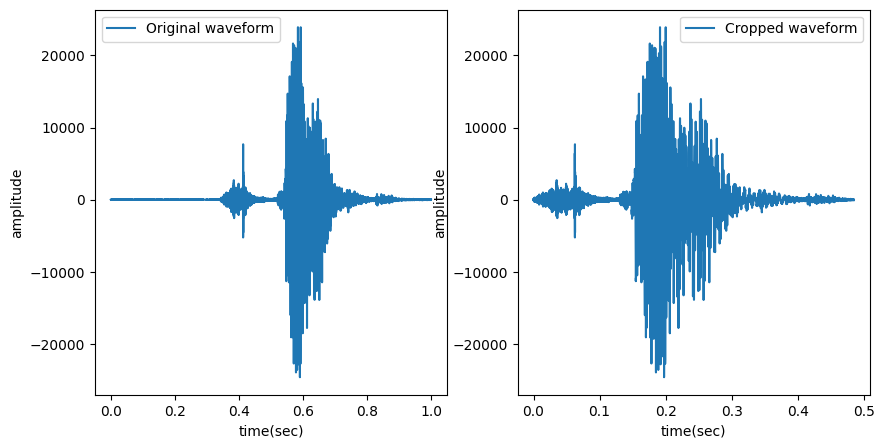

In [19]:
f_samp = commands[7][3][0] # [command][speaker][position in inner list]
sig = commands[7][3][1]
dur = commands[7][3][2]
print("Length of original signal",len(sig))
print("Duration of original signal",dur)

f_samp_cropped = commands_cropped[7][3][0] # [command][speaker][position in inner list]
sig_cropped = commands_cropped[7][3][1]
dur_cropped = commands_cropped[7][3][2]
print("Length of cropped signal",len(sig_cropped))
print("Duration of cropped signal",dur_cropped)

plt.figure(figsize=(10,5))
#print("For the first file of the first command")
t = np.linspace(0,dur,len(sig))
plt.subplot(1,2,1)
plt.plot(t,sig,label="Original waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
        
t = np.linspace(0,dur_cropped,len(sig_cropped))
plt.subplot(1,2,2)
plt.plot(t,sig_cropped,label="Cropped waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
#plt.title("For the first file of the first command")
plt.show()

In [20]:
Audio(sig,rate=f_samp)

In [21]:
Audio(sig_cropped,rate=f_samp_cropped)

In the original signal, we can hear some silence in the beginning which is not present in the cropped signal.

### 2. Speech Activity Detection (SAD)
---
A combination of ZCR and energy thresholds has been used to calculate the speech segment end-points. \
By the hit and trial method, I concluded that if the ZCR at a sample is less than 50% of the maximum ZCR and the energy is more than 0.25% of the maximum energy than the sample is a part of the speech segment. If no sample satisfies these constraints then the zcr threshold is increased by 0.075 iteratively for a maximum of 3 iterations. If we are still unable to find any voiced segment then the cropped segment obtained from the amplitude-based method is used.\
Reference 1 : https://swayattadaw.medium.com/speech-processing-pitch-detection-using-python-b341ec77ce0a \
Reference 2 : https://github.com/hbuschme/speech-processing/blob/master/sp.py

#### Processing on a subset of the dataset

*****************************************************NEW UTTERANCE**********************************************************************************


<Figure size 500x200 with 0 Axes>

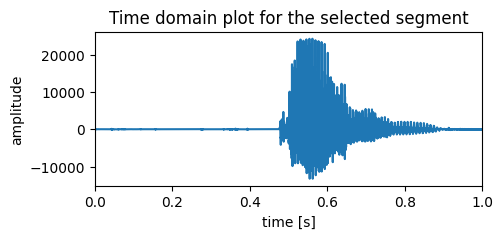

-------------------------------------------------------------------------------------------------------------------------------
Plotting pitch contours
Note: Pitch is only valid for voiced region as it is defined as the rate of vibration of the vocal folds.
So technically we can choose this region to be voiced but let's compute other parameters like energy, ZCR and ACF for better understanding.
Speech Segment =  0.5  to  0.87


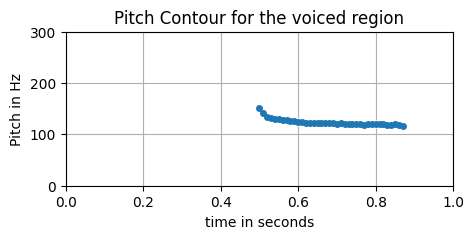

The maximum pitch frequency is =  152.283171653572  at time t =  0.5  seconds
The minimum pitch frequency is =  117.22762621894096  at time t =  0.87  seconds


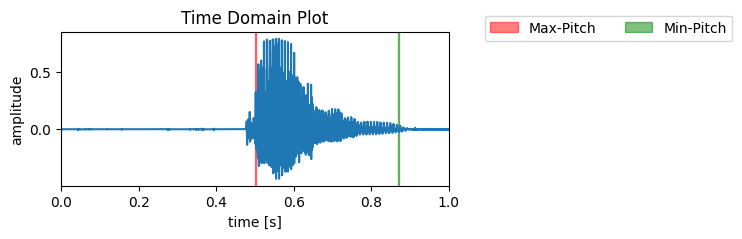

-------------------------------------------------------------------------------------------------------------------------------
Plotting Energy of the signal vs time
Note: Silence has low energy/SNR. However, some unvoiced sounds which also have low SNR may get lost if only this method is used


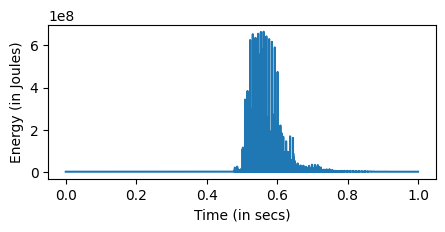

Maximum Energy = 665072521.0 J
-------------------------------------------------------------------------------------------------------------------------------
Plotting ZCR of the signal vs time
Note: ZCR corresponds to the most dominant frequency. Thus, unvoiced sounds have a high ZCR.


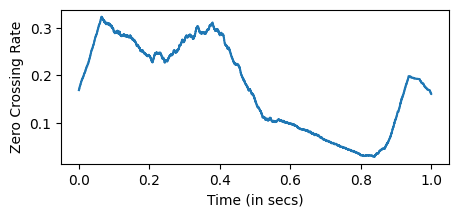

-------------------------------------------------------------------------------------------------------------------------------
Plotting ACF of the signal vs time


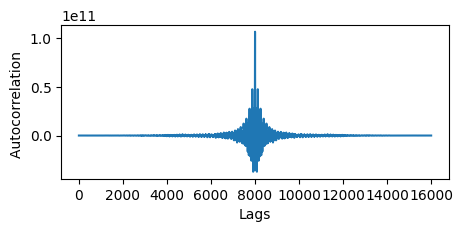

-------------------------------------------------------------------------------------------------------------------------------
Combining Energy and ZCR for Speech Activity Detection
ZCR vlaues have been scaled for comparison with Energy


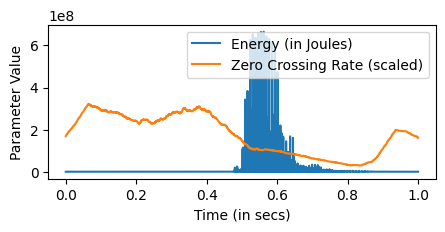

Calculated Speech Segment =  0.4785625  to  0.8578125
*****************************************************NEW UTTERANCE**********************************************************************************


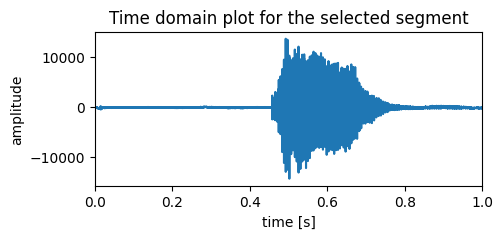

-------------------------------------------------------------------------------------------------------------------------------
Plotting pitch contours
Note: Pitch is only valid for voiced region as it is defined as the rate of vibration of the vocal folds.
So technically we can choose this region to be voiced but let's compute other parameters like energy, ZCR and ACF for better understanding.
Speech Segment =  0.47000000000000003  to  0.77


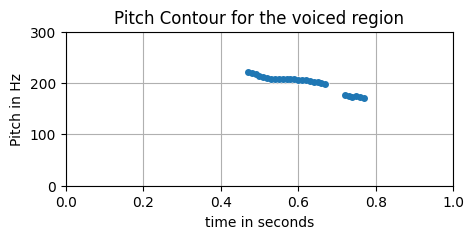

The maximum pitch frequency is =  222.14056226428485  at time t =  0.47000000000000003  seconds
The minimum pitch frequency is =  171.62166789213936  at time t =  0.77  seconds


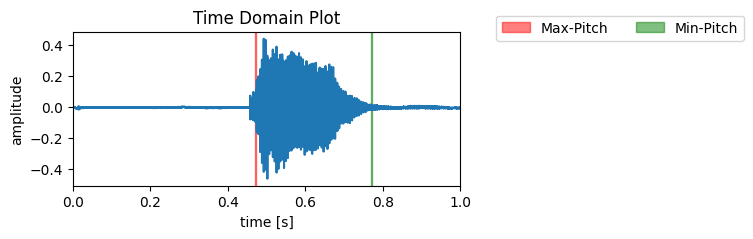

-------------------------------------------------------------------------------------------------------------------------------
Plotting Energy of the signal vs time
Note: Silence has low energy/SNR. However, some unvoiced sounds which also have low SNR may get lost if only this method is used


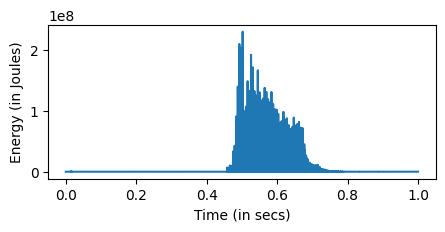

Maximum Energy = 230766481.0 J
-------------------------------------------------------------------------------------------------------------------------------
Plotting ZCR of the signal vs time
Note: ZCR corresponds to the most dominant frequency. Thus, unvoiced sounds have a high ZCR.


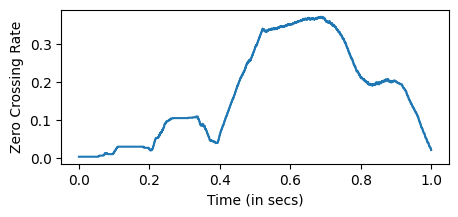

-------------------------------------------------------------------------------------------------------------------------------
Plotting ACF of the signal vs time


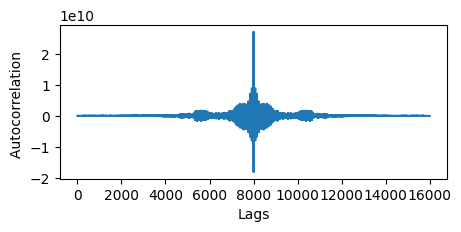

-------------------------------------------------------------------------------------------------------------------------------
Combining Energy and ZCR for Speech Activity Detection
ZCR vlaues have been scaled for comparison with Energy


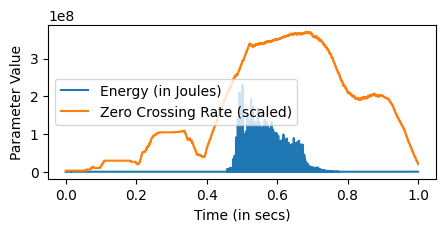

Calculated Speech Segment =  0.45775  to  0.46037500000000003


In [22]:
plt.figure(figsize=(5,2))
#Extracted folders
train_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train'
commands_speech = []
for command in os.listdir(train_folder)[:1]:
    command_folder = os.path.join(train_folder,command)
    command_speech = []
    for filename in os.listdir(command_folder)[:2]:
        print("*****************************************************NEW UTTERANCE**********************************************************************************")
        file = os.path.join(command_folder,filename)
        f_samp, sig = wavfile.read(file)
        #print("The number of samples = ",len(sig))
        sig = sig.astype(float)
        dur = len(sig)/f_samp
        snd = parselmouth.Sound(file)
        snd_part = snd.extract_part(from_time=0,to_time = dur, preserve_times=True)
        #print(snd_part.values.T)
        #print(snd_part.values.T*30853)

        # Time-domain plot
        #plt.figure()
        plt.figure(figsize=(5,2))
        plt.plot(snd_part.xs(), snd_part.values.T*30853) # Multiplied by 30853 to unnormalize
        plt.xlim([snd_part.xmin, snd_part.xmax])
        plt.xlabel("time [s]")
        plt.ylabel("amplitude")
        plt.title("Time domain plot for the selected segment")
        plt.show()
        
        print("-------------------------------------------------------------------------------------------------------------------------------")
        print("Plotting pitch contours")
        print("Note: Pitch is only valid for voiced region as it is defined as the rate of vibration of the vocal folds.")
        print("So technically we can choose this region to be voiced but let's compute other parameters like energy, ZCR and ACF for better understanding.")
        # Getting the sound segment's pitch 
        pitch = snd_part.to_pitch()
        pitch_values = pitch.selected_array['frequency']
        #print(np.nonzero(pitch_values))
        nonzero = np.nonzero(pitch_values)
        #print(len(pitch_values))
        #time = np.arange(0,dur,1/f_samp)
        print("Speech Segment = ",pitch.xs()[nonzero[0][0]]," to ",pitch.xs()[nonzero[0][-1]])
    
        #plt.figure()
        plt.figure(figsize=(5,2))
        # Passing the parameter to the function plot_pitch to plot the pitch contour
        plot_pitch(pitch)
        plt.xlim([snd_part.xmin, snd_part.xmax])
        plt.title('Pitch Contour for the voiced region')
        plt.show()

        # Calculating the maximum and the minimum pitch frequencies in the segment
        max, min = max_min_pitch(pitch)
        print("The maximum pitch frequency is = ",max[0]," at time t = ",max[1]," seconds")
        print("The minimum pitch frequency is = ",min[0]," at time t = ",min[1]," seconds")

        # Highlighting the region of maximum and minimum frequency
        #plt.figure()
        plt.figure(figsize=(5,2))
        plt.plot(snd.xs(), snd.values.T)
        plt.xlim([snd_part.xmin, snd_part.xmax])
        plt.xlabel("time [s]")
        plt.ylabel("amplitude")
        plt.axvspan(max[1],max[1]+0.002, color = 'red', alpha = 0.5, label = "Max-Pitch")
        plt.axvspan(min[1],min[1]+0.002, color = 'green' , alpha = 0.5, label = "Min-Pitch" )

        plt.legend(bbox_to_anchor =(1.75, 1.15), ncol = 2) 
        plt.title('Time Domain Plot')
        plt.show()

        
        print("-------------------------------------------------------------------------------------------------------------------------------")
        print("Plotting Energy of the signal vs time")
        print("Note: Silence has low energy/SNR. However, some unvoiced sounds which also have low SNR may get lost if only this method is used")

        start = math.ceil(0 * f_samp)
        stop = math.ceil(dur * f_samp)

        #Creating the time vector
        time = np.arange(0,dur,1/f_samp)
        Energy = np.square(sig, dtype= np.float64)

        %matplotlib inline
        plt.figure(figsize=(5,2))
        plt.xlabel('Time (in secs)')
        plt.ylabel('Energy (in Joules)')
        plt.plot(time[start:stop], Energy[start:stop])
        plt.show()
        print("Maximum Energy = {e} J".format( e = np.amax(Energy[start:stop])))
        

        print("-------------------------------------------------------------------------------------------------------------------------------")
        print("Plotting ZCR of the signal vs time")
        print("Note: ZCR corresponds to the most dominant frequency. Thus, unvoiced sounds have a high ZCR.")
        # Zero crossings
        #zc = np.asarray([int(x) for x in librosa.zero_crossings(sig[start:stop])]) # Computes the zero crossings of the signal
        zcr = np.asarray([x for x in librosa.feature.zero_crossing_rate(sig[start:stop],hop_length=1)])
        #print(zc)
        #print(len(sig))
        #print(len(zc))
        #print(zcr.shape)

        %matplotlib inline
        plt.figure(figsize=(5,2))
        plt.xlabel('Time (in secs)')
        plt.ylabel('Zero Crossing Rate')
        #plt.plot(time[start:stop], zc[start:stop])
        plt.plot(time[start:stop],zcr[0][1:])
        plt.show()
        #print("Total zero crossings in the frame is = ",sum(zc))

        print("-------------------------------------------------------------------------------------------------------------------------------")
        print("Plotting ACF of the signal vs time")
        autocorr = signal.correlate(sig[start:stop],sig[start:stop],mode = 'same',method = 'auto')
        %matplotlib inline
        plt.figure(figsize=(5,2))
        plt.xlabel('Lags')
        plt.ylabel('Autocorrelation ')
        plt.plot(autocorr)
        plt.show()

        print("-------------------------------------------------------------------------------------------------------------------------------")
        print("Combining Energy and ZCR for Speech Activity Detection")
        print("ZCR vlaues have been scaled for comparison with Energy")
        %matplotlib inline
        plt.figure(figsize=(5,2))
        plt.xlabel('Time (in secs)')
        plt.ylabel('Parameter Value')
        plt.plot(time[start:stop], Energy[start:stop],label="Energy (in Joules)")
        plt.plot(time[start:stop],zcr[0][1:]*10**9,label="Zero Crossing Rate (scaled)")
        plt.legend()
        plt.show()

        # Finding the voiced segment
        voiced_indices = []
        for i in range(len(Energy[start:stop])):
            if(Energy[start:stop][i]>0.25/100*np.max(Energy[start:stop]) and zcr[0][1:][i]<0.57*np.max(zcr[0][1:])): # Fractions of max values obtained by hit and trial
                voiced_indices.append(i)
        #print(voiced_indices)
        print("Calculated Speech Segment = ",time[voiced_indices[0]]," to ",time[voiced_indices[-1]])
        beg = voiced_indices[0]
        end = voiced_indices[-1]
        f_samp_cropped = f_samp
        sig_cropped = sig[beg:end]
        dur_cropped = len(sig_cropped)/f_samp
        command_speech.append([f_samp_cropped,sig_cropped,dur_cropped])
    commands_speech.append(command_speech)
        

Problematic case where ZCR and energy are both high in the speech segment.

Length of original signal 16000
Duration of original signal 1.0
Length of cropped signal 6068
Duration of cropped signal 0.37925


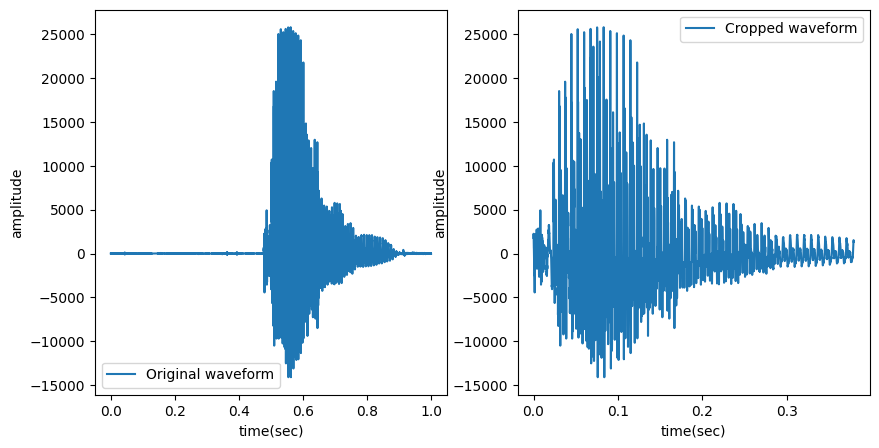

In [23]:
f_samp = commands[0][0][0] # [command][speaker][position in inner list]
sig = commands[0][0][1]
dur = commands[0][0][2]
print("Length of original signal",len(sig))
print("Duration of original signal",dur)

f_samp_cropped = commands_speech[0][0][0] # [command][speaker][position in inner list]
sig_cropped = commands_speech[0][0][1]
dur_cropped = commands_speech[0][0][2]
print("Length of cropped signal",len(sig_cropped))
print("Duration of cropped signal",dur_cropped)

plt.figure(figsize=(10,5))
#print("For the first file of the first command")
t = np.linspace(0,dur,len(sig))
plt.subplot(1,2,1)
plt.plot(t,sig,label="Original waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
        
t = np.linspace(0,dur_cropped,len(sig_cropped))
plt.subplot(1,2,2)
plt.plot(t,sig_cropped,label="Cropped waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
#plt.title("For the first file of the first command")
plt.show()

In [24]:
Audio(sig,rate=f_samp)

In [25]:
Audio(sig_cropped,rate=f_samp_cropped)

#### Processing on all the commands dataset (using only 100 utterances of each command)

In [26]:
plt.figure(figsize=(5,2))
#Extracted folders
train_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train'
cropped_commands = []
for command in os.listdir(train_folder):
    command_ind = os.listdir(train_folder).index(command)
    print("***************************************NEW COMMAND*************************************************************************")
    print(command)
    command_folder = os.path.join(train_folder,command)
    cropped_command = []
    #for filename in os.listdir(command_folder):
    for i in tqdm (range (len(os.listdir(command_folder)[:100])), desc="Loading..."):  # Using only 100 utterances of each command due to lack of computational resources 
        file_ind = i
        filename = os.listdir(command_folder)[i]
        #print("*****************************************************NEW UTTERANCE**********************************************************************************")
        file = os.path.join(command_folder,filename)
        f_samp, sig = wavfile.read(file)
        #print("The number of samples = ",len(sig))
        sig = sig.astype(float)
        dur = len(sig)/f_samp
        #snd = parselmouth.Sound(file)
        #snd_part = snd.extract_part(from_time=0,to_time = dur, preserve_times=True)
        #print(snd_part.values.T)
        #print(snd_part.values.T*30853)
        
        #print("-------------------------------------------------------------------------------------------------------------------------------")
        #print("Plotting Energy of the signal vs time")
        #print("Note: Silence has low energy/SNR. However, some unvoiced sounds which also have low SNR may get lost if only this method is used")

        start = math.ceil(0 * f_samp)
        stop = math.ceil(dur * f_samp)

        #Creating the time vector
        time = np.arange(0,dur,1/f_samp)
        Energy = np.square(sig, dtype= np.float64)
        

        #print("-------------------------------------------------------------------------------------------------------------------------------")
        #print("Plotting ZCR of the signal vs time")
        #print("Note: ZCR corresponds to the most dominant frequency. Thus, unvoiced sounds have a high ZCR.")
        # Zero crossings
        #zc = np.asarray([int(x) for x in librosa.zero_crossings(sig[start:stop])]) # Computes the zero crossings of the signal
        zcr = np.asarray([x for x in librosa.feature.zero_crossing_rate(sig[start:stop],hop_length=1)])

        #print("-------------------------------------------------------------------------------------------------------------------------------")
        #print("Combining Energy and ZCR for Speech Activity Detection")
        #print("ZCR vlaues have been scaled for comparison with Energy")

        # Finding the voiced segment
        voiced_ind = []
        zcr_thresh = 0.5
        for i in range(len(Energy[start:stop])):
            if(Energy[start:stop][i]>0.25/100*np.max(Energy[start:stop]) and zcr[0][1:][i]<zcr_thresh*np.max(zcr[0][1:])): # Fractions of max values obtained by hit and trial
                voiced_ind.append(i)
        #print("Calculated Speech Segment = ",time[voiced_indices[0]]," to ",time[voiced_indices[-1]])
        #print(voiced_ind[0])
        count = 0
        while(len(voiced_ind)==0):
            zcr_thresh+= 0.075
            count+= 1
            if(count <= 2):
                #print("zcr_thresh increased")
                for i in range(len(Energy[start:stop])):
                    if(Energy[start:stop][i]>0.25/100*np.max(Energy[start:stop]) and zcr[0][1:][i]<zcr_thresh*np.max(zcr[0][1:])): # Fractions of max values obtained by hit and trial
                        voiced_ind.append(i)
            else:
                print("While loop exited")
                print("Using amplitude based cropped signal")
                # Using amplitude based cropped signal
                voiced_ind = commands_voiced_ind[command_ind][file_ind]
                #voiced_ind = [i for i in range(len(Energy[start:stop]))]
                break
                
        beg = voiced_ind[0]
        end = voiced_ind[-1]
        f_samp_cropped = f_samp
        #print(len(sig))
        sig_cropped = sig[beg:end]
        dur_cropped = len(sig_cropped)/f_samp
        cropped_command.append([f_samp_cropped,sig_cropped,dur_cropped])
    cropped_commands.append(cropped_command)
        

***************************************NEW COMMAND*************************************************************************
down


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


***************************************NEW COMMAND*************************************************************************
go


Loading...:  68%|██████████████████████████████████████████████▉                      | 68/100 [00:53<00:32,  1.03s/it]

While loop exited
Using amplitude based cropped signal


Loading...:  70%|████████████████████████████████████████████████▎                    | 70/100 [00:56<00:35,  1.19s/it]

While loop exited
Using amplitude based cropped signal


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


***************************************NEW COMMAND*************************************************************************
left


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


***************************************NEW COMMAND*************************************************************************
no


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.28it/s]


***************************************NEW COMMAND*************************************************************************
off


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


***************************************NEW COMMAND*************************************************************************
on


Loading...: 100%|█████████████████████████████████████████████████████████████████| 100/100 [8:46:42<00:00, 316.02s/it]


***************************************NEW COMMAND*************************************************************************
right


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


***************************************NEW COMMAND*************************************************************************
stop


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


***************************************NEW COMMAND*************************************************************************
up


Loading...:  10%|██████▉                                                              | 10/100 [00:10<01:37,  1.09s/it]

While loop exited
Using amplitude based cropped signal


Loading...:  38%|██████████████████████████▏                                          | 38/100 [00:39<01:25,  1.38s/it]

While loop exited
Using amplitude based cropped signal


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


***************************************NEW COMMAND*************************************************************************
yes


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


<Figure size 500x200 with 0 Axes>

Length of original signal 16000
Duration of original signal 1.0
Length of cropped signal 3269
Duration of cropped signal 0.2043125


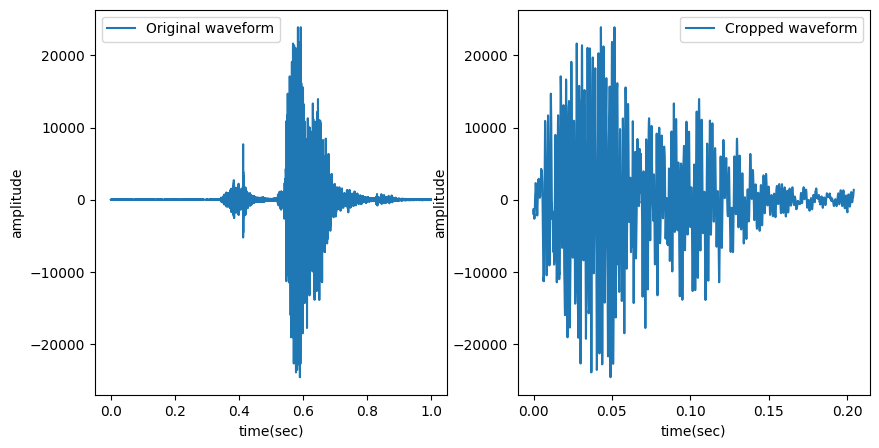

In [27]:
f_samp = commands[7][3][0] # [command][speaker][position in inner list]
sig = commands[7][3][1]
dur = commands[7][3][2]
print("Length of original signal",len(sig))
print("Duration of original signal",dur)

f_samp_cropped = cropped_commands[7][3][0] # [command][speaker][position in inner list]
sig_cropped = cropped_commands[7][3][1]
dur_cropped = cropped_commands[7][3][2]
print("Length of cropped signal",len(sig_cropped))
print("Duration of cropped signal",dur_cropped)

plt.figure(figsize=(10,5))
#print("For the first file of the first command")
t = np.linspace(0,dur,len(sig))
plt.subplot(1,2,1)
plt.plot(t,sig,label="Original waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
        
t = np.linspace(0,dur_cropped,len(sig_cropped))
plt.subplot(1,2,2)
plt.plot(t,sig_cropped,label="Cropped waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
#plt.title("For the first file of the first command")
plt.show()

In [28]:
Audio(sig,rate=f_samp)

In [29]:
Audio(sig_cropped,rate=f_samp_cropped)

### Comment
---
Amplitude/Energy based method gives better results for words which contain plosives, fricatives etc. (for eg. "stop". In the waveform for "stop", there is a low amplitude region in the middle of the speech segment which is skipped by the SAD method but not by the amplitude/energy based method.)

## Pre-emphasis 

In [30]:
pre_emp_commands_cropped = []
for command_cropped in commands_cropped:
    pre_emp_command_cropped = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(command_cropped)), desc="Loading..."):
        utterance = command_cropped[i]
        f_samp = utterance[0]
        sig = utterance[1]
        dur = utterance[2]
        pre_emp_sig = pre_emphasis(sig)
        pre_emp_command_cropped.append([f_samp,pre_emp_sig,dur])
    pre_emp_commands_cropped.append(pre_emp_command_cropped)

Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 130.23it/s]


Length of original signal 16000
Duration of original signal 1.0
Length of cropped signal 7753
Duration of cropped signal 0.4845625
Length of cropped signal 7753
Duration of cropped signal 0.4845625


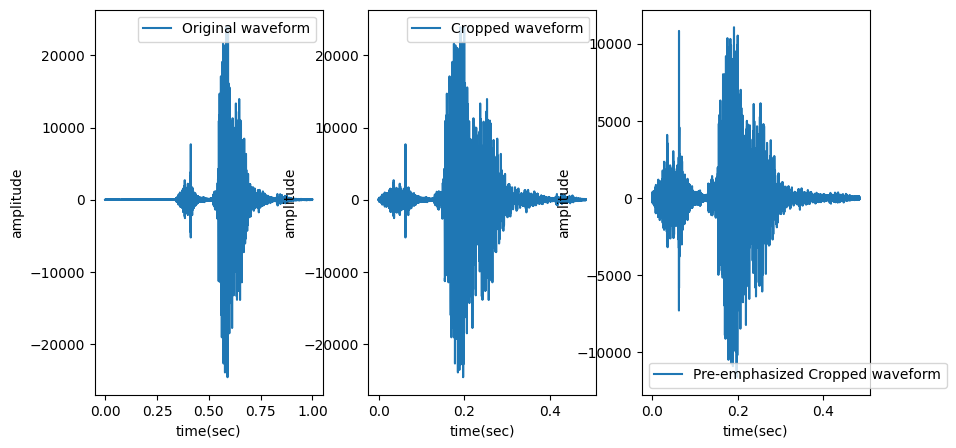

In [31]:
f_samp = commands[7][3][0] # [command][speaker][position in inner list]
sig = commands[7][3][1]
dur = commands[7][3][2]
print("Length of original signal",len(sig))
print("Duration of original signal",dur)

f_samp_cropped = commands_cropped[7][3][0] # [command][speaker][position in inner list]
sig_cropped = commands_cropped[7][3][1]
dur_cropped = commands_cropped[7][3][2]
print("Length of cropped signal",len(sig_cropped))
print("Duration of cropped signal",dur_cropped)

f_samp_cropped_pre = pre_emp_commands_cropped[7][3][0] # [command][speaker][position in inner list]
sig_cropped_pre = pre_emp_commands_cropped[7][3][1]
dur_cropped_pre = pre_emp_commands_cropped[7][3][2]
print("Length of cropped signal",len(sig_cropped_pre))
print("Duration of cropped signal",dur_cropped_pre)

plt.figure(figsize=(10,5))
#print("For the first file of the first command")
t = np.linspace(0,dur,len(sig))
plt.subplot(1,3,1)
plt.plot(t,sig,label="Original waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
        
t = np.linspace(0,dur_cropped,len(sig_cropped))
plt.subplot(1,3,2)
plt.plot(t,sig_cropped,label="Cropped waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()

t = np.linspace(0,dur_cropped_pre,len(sig_cropped_pre))
plt.subplot(1,3,3)
plt.plot(t,sig_cropped_pre,label="Pre-emphasized Cropped waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
#plt.title("For the first file of the first command")
plt.show()

In [32]:
Audio(sig,rate=f_samp)

In [33]:
Audio(sig_cropped,rate=f_samp_cropped)

In [34]:
Audio(sig_cropped_pre,rate=f_samp_cropped_pre)

## MFCC Feature Extraction
---
Reference: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

### Framing and Windowing
---
$\textbf{Framing}$ \
After pre-emphasis, we need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it doesn’t make sense to do the Fourier transform across the entire signal in that we would lose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.0

$\textbf{Windowing}$ \
After slicing the signal into frames, we apply a window function such as the Hamming window to each frame. A Hamming window has the following form: 
\begin{equation}
w[n] = 0.54 - 0.46cos(\frac{2\pi n}{N-1})
\end{equation}
where, $0 \le n \le N-1$, N is the window length. \
There are several reasons why we need to apply a window function to the frames, notably to counteract the assumption made by the FFT that the data is infinite and to reduce spectral leakage.1.

In [35]:
windowed_commands = []
for pre_emp_command_cropped in pre_emp_commands_cropped:
    windowed_command = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(pre_emp_command_cropped)), desc="Loading..."):
        utterance = pre_emp_command_cropped[i]
        f_samp = utterance[0]
        sig = utterance[1]
        dur = utterance[2]
        frames,frame_length = framing(emphasized_signal=sig,sample_rate=f_samp)
        windowed_sig = windowing(frames,frame_length)
        windowed_command.append([f_samp,windowed_sig,dur])
    windowed_commands.append(windowed_command)

Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 870.74it/s]


In [36]:
windowed_sig = windowed_commands[1][0][1]
print(windowed_sig.shape)

(65, 400)


### Fourier Transform and Power Spectrum
---
We can now do an N
-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), wher N 
 is typically 256 or 512, NFFT = 512; and then compute the power spectrum (periodogram) using the following equatio
\begin{equation}
P = \frac{|FFT(x_i)|^2}{N}
\end{equation}nwhere, $x_i$ is the $i^{th}$ frame of the signal x.



In [37]:
pow_commands = []
for windowed_command in windowed_commands:
    pow_command = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(windowed_command)), desc="Loading..."):
        utterance = windowed_command[i]
        f_samp = utterance[0]
        windowed_sig = utterance[1]
        dur = utterance[2]
        pow_sig = fft_and_pow_spectrum(windowed_sig)
        pow_command.append([f_samp,pow_sig,dur])
    pow_commands.append(pow_command)

Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1633.55it/s]


### Filter Banks
---
The final step to computing filter banks is applying triangular filters, typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands. The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. We can convert between Hertz (f
) and Mel m
) using the following equation
\begin{equation}
m = 2595log_{10}(1+\frac{f}{700})
\end{equation}
\begin{equation}
f = 700(100^{m/2595}-1)
\end{equation}
Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0.s:

In [38]:
mfb_commands = []
for pow_command in pow_commands:
    mfb_command = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(pow_command)), desc="Loading..."):
        utterance = pow_command[i]
        f_samp = utterance[0]
        pow_sig = utterance[1]
        dur = utterance[2]
        mfb_sig = mel_filter_bank(pow_frames=pow_sig,sample_rate=f_samp)
        mfb_command.append([f_samp,mfb_sig,dur])
    mfb_commands.append(mfb_command)

Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 708.82it/s]


### Mel-frequency Cepstral Coefficients (MFCCs)
---
It turns out that filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded; num_ceps = 12. The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR). 
One may apply sinusoidal liftering1 to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals.

In [39]:
mfcc_commands = []
for mfb_command in mfb_commands:
    mfcc_command = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(mfb_command)), desc="Loading..."):
        utterance = mfb_command[i]
        f_samp = utterance[0]
        filter_banks = utterance[1]
        dur = utterance[2]
        mfcc_sig = mfcc(filter_banks)
        mfcc_command.append([f_samp,mfcc_sig,dur])
    mfcc_commands.append(mfcc_command)

Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4795.57it/s]


## Training the model using GMM-HMM Method
---
Train an HMM for each word/command. \
Reference: https://github.com/MaharshiYeluri01/SpeechRecognition/blob/master/Speech_recognition_5.ipynb]

In [79]:
class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []

        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components, 
                    covariance_type=self.cov_type, n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')

    # X is a 2D numpy array where each row is 13D
    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))

    # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)

In [103]:
hmm_models = []
train_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train'
for command_ind,mfcc_command in enumerate(mfcc_commands):
    #command_ind = mfcc_commands.index(mfcc_command)
    #print(command_ind)
    command = os.listdir(train_folder)[command_ind] # =label
    print(command)
    label = command
    #for utterance in command_cropped:
    X = np.array([])
    y_words = []
    for i in tqdm (range (len(mfcc_command)), desc="Loading..."):
        utterance = mfcc_command[i]
        f_samp = utterance[0]
        mfcc_features = utterance[1]
        #print(mfcc_features.shape)
        dur = utterance[2]
        if len(X) == 0:
            X = mfcc_features
        else:
            X = np.append(X, mfcc_features, axis=0)
        y_words.append(label)
    #print(len(y_words))
    print('X.shape =', X.shape)
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X)
    #print(hmm_trainer)
    hmm_models.append((hmm_trainer, label))
    hmm_trainer = None

down


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 9613.79it/s]

X.shape = (6685, 12)


go


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8559.11it/s]

X.shape = (6133, 12)


left


Loading...: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 10507.04it/s]

X.shape = (6090, 12)


no


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6669.16it/s]

X.shape = (6276, 12)


off


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6149.37it/s]

X.shape = (6038, 12)


on


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5621.49it/s]

X.shape = (6755, 12)


right


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5046.75it/s]

X.shape = (6351, 12)


stop


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8976.96it/s]

X.shape = (6462, 12)


up


Loading...: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 15975.26it/s]

X.shape = (5094, 12)


yes


Loading...: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 11938.36it/s]

X.shape = (6759, 12)


## Task A: Recognition of clean speech utterances

### Pre-processing test dataset

In [81]:
#Extracted folders
test_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\test\test_clean'
commands_test = []
for command in os.listdir(test_folder):
    command_folder = os.path.join(test_folder,command)
    command_test = []
    for filename in os.listdir(command_folder):
        file = os.path.join(command_folder,filename)
        f_samp, sig = wavfile.read(file)
        #print("The number of samples = ",len(sig))
        sig = sig.astype(float)
        dur = len(sig)/f_samp
        #print("The sampling frequency of the signal is = ",f_samp, "Hz")
        #print("The duration of the signal is:",dur, "seconds")
        command_test.append([f_samp,sig,dur])
    commands_test.append(command_test)

#### Speech End-pointing
---
1. Method 1: Amplitude-based. We will only keep samples which have an amplitude greater than 0.25% of the maximum amplitude of the signal and assume that the rest is silence.
2. Method 2: Speech Activity Detection (SAD)

##### 1. Amplitude/Energy based

In [132]:
commands_cropped_test = []
commands_voiced_ind_test = []
for command in commands_test:
    #print(command)
    command_cropped_test = []
    command_voiced_ind_test = []
    #for file in command:
    for i in tqdm (range (len(command)), desc="Loading..."): # Using only 100 utterances of each command due to lack of computational resources
        file = command[i]
        #print(file)
        f_samp = file[0]
        sig = file[1]
        dur = file[2]
        max_amp = np.max(sig)
        #print("Maximum Amplitude",max_amp)
        #print("Minimum absolute Amplitude",np.min(np.abs(sig)))
        #print(0.25*max_amp)
        sig_cropped = []
        #print(sig)
        voiced_indices_amp_test = []
        for samp in sig:
            #print(samp)
            if(np.abs(samp)>0.25/100*max_amp): # Only keep samples having amplitude > 0.25% of the max amplitude
                #print("Yes")
                sig_cropped.append(samp)
                voiced_indices_amp_test.append(list(sig).index(samp))
            #else:
                #print("No")
        sig_cropped = np.array(sig_cropped)
        #print(len(sig_cropped))
        dur_cropped = len(sig_cropped)/f_samp
        #print(dur_cropped)
        command_cropped_test.append([f_samp,sig_cropped,dur_cropped])
        command_voiced_ind_test.append(voiced_indices_amp_test)
    commands_cropped_test.append(command_cropped_test)
    commands_voiced_ind_test.append(command_voiced_ind_test)
        
        #plt.figure(figsize=(10,5))
        
        #ind1 = random.randint(0,len(commands))
        #ind2 = random.randint(0,len(com))
        #if(file == commands[0][0]):        

Loading...: 100%|██████████████████████████████████████████████████████████████████| 256/256 [2:23:33<00:00, 33.65s/it]


#### Pre-emphasis 

In [133]:
pre_emp_commands_cropped_test = []
for command_cropped_test in commands_cropped_test:
    pre_emp_command_cropped_test = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(command_cropped_test)), desc="Loading..."):
        utterance = command_cropped_test[i]
        f_samp = utterance[0]
        sig = utterance[1]
        dur = utterance[2]
        pre_emp_sig = pre_emphasis(sig)
        pre_emp_command_cropped_test.append([f_samp,pre_emp_sig,dur])
    pre_emp_commands_cropped_test.append(pre_emp_command_cropped_test)

Loading...: 100%|███████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 163.85it/s]


Length of original signal 16000
Duration of original signal 1.0
Length of cropped signal 13666
Duration of cropped signal 0.854125
Length of cropped signal 13666
Duration of cropped signal 0.854125


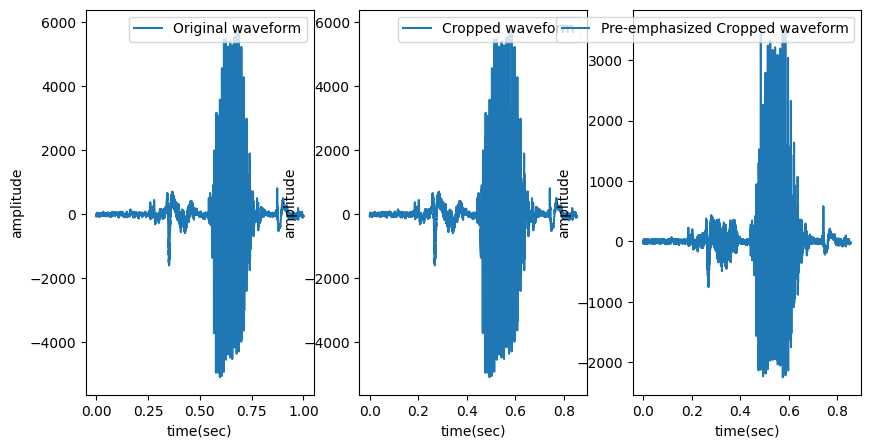

In [134]:
f_samp = commands_test[7][3][0] # [command][speaker][position in inner list]
sig_test = commands_test[7][3][1]
dur_test = commands_test[7][3][2]
print("Length of original signal",len(sig_test))
print("Duration of original signal",dur_test)

f_samp_cropped = commands_cropped_test[7][3][0] # [command][speaker][position in inner list]
sig_cropped_test = commands_cropped_test[7][3][1]
dur_cropped_test = commands_cropped_test[7][3][2]
print("Length of cropped signal",len(sig_cropped_test))
print("Duration of cropped signal",dur_cropped_test)

f_samp_cropped_pre = pre_emp_commands_cropped_test[7][3][0] # [command][speaker][position in inner list]
sig_cropped_pre_test = pre_emp_commands_cropped_test[7][3][1]
dur_cropped_pre_test = pre_emp_commands_cropped_test[7][3][2]
print("Length of cropped signal",len(sig_cropped_pre_test))
print("Duration of cropped signal",dur_cropped_pre_test)

plt.figure(figsize=(10,5))
#print("For the first file of the first command")
t = np.linspace(0,dur_test,len(sig_test))
plt.subplot(1,3,1)
plt.plot(t,sig_test,label="Original waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
        
t = np.linspace(0,dur_cropped_test,len(sig_cropped_test))
plt.subplot(1,3,2)
plt.plot(t,sig_cropped_test,label="Cropped waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()

t = np.linspace(0,dur_cropped_pre_test,len(sig_cropped_pre_test))
plt.subplot(1,3,3)
plt.plot(t,sig_cropped_pre_test,label="Pre-emphasized Cropped waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
#plt.title("For the first file of the first command")
plt.show()

In [135]:
Audio(sig_test,rate=f_samp)

In [136]:
Audio(sig_cropped_test,rate=f_samp_cropped)

In [137]:
Audio(sig_cropped_pre_test,rate=f_samp_cropped_pre)

#### MFCC Feature Extraction

In [138]:
mfcc_commands_test = []
for pre_emp_command_cropped_test in pre_emp_commands_cropped_test:
    mfcc_command_test = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(pre_emp_command_cropped_test)), desc="Loading..."):
        utterance = pre_emp_command_cropped_test[i]
        f_samp = utterance[0]
        sig = utterance[1]
        dur = utterance[2]
        frames,frame_length = framing(emphasized_signal=sig,sample_rate=f_samp)
        windowed_sig = windowing(frames,frame_length)
        pow_sig = fft_and_pow_spectrum(windowed_sig)
        mfb_sig = mel_filter_bank(pow_frames=pow_sig,sample_rate=f_samp)
        mfcc_sig = mfcc(mfb_sig)
        mfcc_command_test.append([f_samp,mfcc_sig,dur])
    mfcc_commands_test.append(mfcc_command_test)

Loading...: 100%|███████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 451.80it/s]


### Testing

In [139]:
correct_commands = 0
num_files = 0
actual = []
predicted = []
for command_ind,mfcc_command_test in enumerate(mfcc_commands_test):
    #command_ind = mfcc_commands.index(mfcc_command)
    #print(command_ind)
    correct_command = 0
    actual_command = []
    predicted_command = []
    predicted_val = []
    command = os.listdir(train_folder)[command_ind] # =label
    print(command)
    #label = command
    #for utterance in command_cropped:
    X = np.array([])
    y_words = []
    #for i in tqdm (range (len(mfcc_command_test)), desc="Loading..."):
    for i in range(len(mfcc_command_test)):
        utterance = mfcc_command_test[i]
        f_samp = utterance[0]
        mfcc_features = utterance[1]
        #print(mfcc_features.shape)
        dur = utterance[2]
        #if len(X) == 0:
        #    X = mfcc_features
        #else:
        #    X = np.append(X, mfcc_features, axis=0)
        #y_words.append(label)
        scores=[]
        for item in hmm_models:
            hmm_model, label = item
            
            score = hmm_model.get_score(mfcc_features)
            scores.append(score)
        index=np.array(scores).argmax()
        #print("\nTrue:", command)
        #print("Predicted:", hmm_models[index][1]) 
        if(command == hmm_models[index][1]):
            correct_command+=1
            correct_commands+=1
            predicted_val.append(command)
        else:
            predicted_val.append('mismatch')
        num_files+=1
        actual_command.append(command)
        predicted_command.append(hmm_models[index][1])
        actual.append(command)
        predicted.append(hmm_models[index][1])
    #print(actual_command)
    #print(predicted_command)
    #compute the confusion matrix.
    #cm = confusion_matrix(actual_command,predicted_val)
    #cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [command,'mismatch'])
    #cm_display.plot()
    #plt.show()
    accuracy_command = correct_command/len(mfcc_command_test)
    print("Accuracy per command: ",accuracy_command)
accuracy = correct_commands/num_files
print("Overall Accuracy: ",accuracy)
    #print(len(y_words))
    #print('X.shape =', X.shape)
    #hmm_trainer = HMMTrainer()
    #hmm_trainer.train(X)
    #print(hmm_trainer)
    #hmm_models.append((hmm_trainer, label))
    #hmm_trainer = None

down
Accuracy per command:  0.6521739130434783
go
Accuracy per command:  0.4103585657370518
left
Accuracy per command:  0.7865168539325843
no
Accuracy per command:  0.5515873015873016
off
Accuracy per command:  0.7022900763358778
on
Accuracy per command:  0.5365853658536586
right
Accuracy per command:  0.7606177606177607
stop
Accuracy per command:  0.642570281124498
up
Accuracy per command:  0.6911764705882353
yes
Accuracy per command:  0.8984375
Overall Accuracy:  0.6653681340085703


### Plotting the confusion matrix

Overall Accuracy:  0.6653681340085703


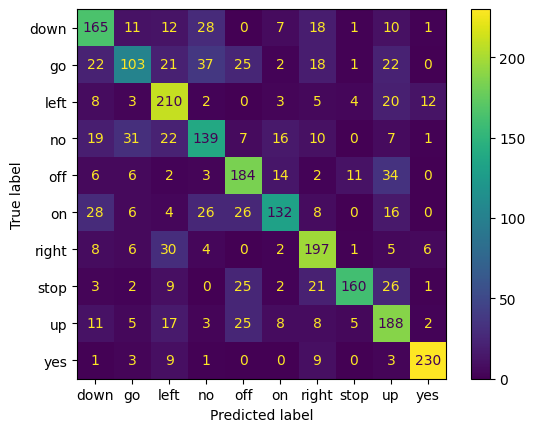

In [140]:
print("Overall Accuracy: ",accuracy)
#compute the confusion matrix.
cm = confusion_matrix(actual,predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = os.listdir(test_folder))
cm_display.plot()

### Comments
---
1. Values are high along the diagonal as expected.
2. The overall model accuracy isn't very high as only 100 utterances of each word were used in the training due to computational limitations. The model accuracy is expected to increase with more training samples.

## Task B: Recognition of noisy utterances

### Pre-processing train dataset
---
Adding noise to the train samples to create new samples. Noise is added to each train sample with a probability of 0.5.

#### Speech End-pointing (No need. Use the cropped commands)
---
1. Method 1: Amplitude-based. We will only keep samples which have an amplitude greater than 0.25% of the maximum amplitude of the signal and assume that the rest is silence.
2. Method 2: Speech Activity Detection (SAD)

##### 1. Amplitude/Energy based (No need. Use the previous one)

In [143]:
"""
commands_noisy_cropped = []
commands_noisy_voiced_ind = []
for command_noisy in commands_noisy:
    #print(command)
    command_noisy_cropped = []
    command_noisy_voiced_ind = []
    #for file in command:
    for i in tqdm (range (len(command_noisy[:100])), desc="Loading..."): # Using only 100 utterances of each command due to lack of computational resources
        file = command_noisy[i]
        #print(file)
        f_samp = file[0]
        sig = file[1]
        dur = file[2]
        max_amp = np.max(sig)
        #print("Maximum Amplitude",max_amp)
        #print("Minimum absolute Amplitude",np.min(np.abs(sig)))
        #print(0.25*max_amp)
        sig_noisy_cropped = []
        #print(sig)
        noisy_voiced_indices_amp = []
        for samp in sig:
            #print(samp)
            if(np.abs(samp)>0.25/100*max_amp): # Only keep samples having amplitude > 0.25% of the max amplitude
                #print("Yes")
                sig_noisy_cropped.append(samp)
                noisy_voiced_indices_amp.append(list(sig).index(samp))
            #else:
                #print("No")
        sig_noisy_cropped = np.array(sig_noisy_cropped)
        #print(len(sig_cropped))
        dur_cropped = len(sig_noisy_cropped)/f_samp
        #print(dur_cropped)
        command_noisy_cropped.append([f_samp,sig_noisy_cropped,dur_cropped])
        command_noisy_voiced_ind.append(noisy_voiced_indices_amp)
    commands_noisy_cropped.append(command_noisy_cropped)
    commands_noisy_voiced_ind.append(command_noisy_voiced_ind)
        
        #plt.figure(figsize=(10,5))
        
        #ind1 = random.randint(0,len(commands))
        #ind2 = random.randint(0,len(com))
        #if(file == commands[0][0]):       
"""

Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [40:44<00:00, 24.45s/it]


#### Comment
---
Noise is directly added to the cropped commands instead of detecting speech after adding noise as the energy-based method would not work for noisy speech signals. \ 
We need to use a combination of energy and ZCR based SAD methods for noisy signals. \

#### Saving cropped utterances to a new folder

In [253]:
#Extracted folders
train_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train'
train_cropped_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train_cropped'
for command_ind,command in enumerate(os.listdir(train_folder)):
    print(command_ind)
    command_cropped = commands_cropped[command_ind]
    print(command)
    command_folder = os.path.join(train_folder,command)
    command_cropped_folder = os.path.join(train_cropped_folder,command)
    if(os.path.exists(command_cropped_folder)):
        shutil.rmtree(command_cropped_folder)
    os.makedirs(command_cropped_folder)
    for i in tqdm (range (len(os.listdir(command_folder)[:100])), desc="Loading..."):
        filename = os.listdir(command_folder)[i]
        file = os.path.join(command_folder,filename)
        f_samp, sig = wavfile.read(file)
        cropped_sig = command_cropped[i][1]
        command_cropped_file = os.path.join(command_cropped_folder,filename[:-4]+'_cropped.wav')
        f = open(command_cropped_file,"w")
        #if os.path.exists(command_cropped_file):
        #    f = open(command_cropped_file,"w")
        #else:
        #    f = open(command_cropped_file,"x")
        cropped_sig = np.array(cropped_sig)
        wavfile.write(command_cropped_file,f_samp,cropped_sig) 
        f.close()

0
down


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.89it/s]


1
go


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 95.36it/s]


2
left


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 98.16it/s]


3
no


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 95.54it/s]


4
off


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.37it/s]


5
on


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 83.49it/s]


6
right


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.14it/s]


7
stop


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 76.93it/s]


8
up


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 71.96it/s]


9
yes


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 71.40it/s]


#### Adding noise to the cropped train dataset

In [254]:
#Extracted folders
train_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train'
train_cropped_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train_cropped'
train_noisy_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train_noisy'
noise_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\_background_noise_'
#commands = []
commands_cropped_noisy = []
for command_ind,command in enumerate(os.listdir(train_cropped_folder)):
    command_cropped = commands_cropped[command_ind]
    print(command_ind)
    print(command)
    command_cropped_folder = os.path.join(train_cropped_folder,command)
    command_noisy_folder = os.path.join(train_noisy_folder,command)
    if(os.path.exists(command_noisy_folder)):
        shutil.rmtree(command_noisy_folder)
    os.makedirs(command_noisy_folder)
    command_cropped_noisy = []
    #for filename in os.listdir(command_folder):
    for i in tqdm (range (len(os.listdir(command_cropped_folder))), desc="Loading..."):
        filename = os.listdir(command_cropped_folder)[i]
        file = os.path.join(command_cropped_folder,filename)
        f_samp, sig = wavfile.read(file)
        #outputfile = os.path.join(command_noisy_folder,filename[:-4]+'_noisy.wav')
        noise_ind = np.random.randint(len(os.listdir(noise_folder)))
        noisefile = os.path.join(noise_folder,os.listdir(noise_folder)[noise_ind])
        if(np.random.randint(2)==1): # randomly adding noise to training samples with 0.5 probability
            outputfile = os.path.join(command_noisy_folder,filename[:-4]+'_noisy.wav')
            outputfile.encode('unicode_escape')
            #print(outputfile)
            if os.path.exists(outputfile):
                f = open(outputfile,"w")
            else:
                f = open(outputfile,"x")
            add_noise(file,noisefile,outputfile)
        else:
            outputfile = os.path.join(command_noisy_folder,filename)
            outputfile.encode('unicode_escape')
            #print(outputfile)
            if os.path.exists(outputfile):
                f = open(outputfile,"w")
            else:
                f = open(outputfile,"x")
            wavfile.write(outputfile,f_samp,sig) 
        f.close()

0
down


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100.92it/s]


1
go


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 104.77it/s]


2
left


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 97.70it/s]


3
no


Loading...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 89.28it/s]


4
off


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 124.50it/s]


5
on


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 110.88it/s]


6
right


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 120.41it/s]


7
stop


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 113.87it/s]


8
up


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.15it/s]


9
yes


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 103.51it/s]


In [255]:
#Extracted folders
train_noisy_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train_noisy'
noise_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\_background_noise_'
#commands = []
commands_noisy_cropped = []
for command in os.listdir(train_noisy_folder):
    print(command)
    command_noisy_folder = os.path.join(train_noisy_folder,command)
    command_noisy_cropped = []
    #for filename in os.listdir(command_noisy_folder):
    for i in tqdm (range (len(os.listdir(command_noisy_folder))), desc="Loading..."):
        filename = os.listdir(command_noisy_folder)[i]
        file = os.path.join(command_noisy_folder,filename)
        f_samp, sig = wavfile.read(file)
        #print("The number of samples = ",len(sig))
        sig = sig.astype(float)
        dur = len(sig)/f_samp
        #print("The sampling frequency of the signal is = ",f_samp, "Hz")
        #print("The duration of the signal is:",dur, "seconds")
        command_noisy_cropped.append([f_samp,sig,dur])
    commands_noisy_cropped.append(command_noisy_cropped)

down


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 944.69it/s]


go


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 906.69it/s]


left


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1088.21it/s]


no


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1118.09it/s]


off


Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 868.93it/s]


on


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1267.35it/s]


right


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1219.10it/s]


stop


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1275.31it/s]


up


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1161.40it/s]


yes


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1048.36it/s]


#### Pre-emphasis

In [256]:
pre_emp_commands_noisy_cropped = []
for command_noisy_cropped in commands_noisy_cropped:
    pre_emp_command_noisy_cropped = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(command_noisy_cropped)), desc="Loading..."):
        utterance = command_noisy_cropped[i]
        f_samp = utterance[0]
        sig = utterance[1]
        dur = utterance[2]
        pre_emp_sig = pre_emphasis(sig)
        pre_emp_command_noisy_cropped.append([f_samp,pre_emp_sig,dur])
    pre_emp_commands_noisy_cropped.append(pre_emp_command_noisy_cropped)

Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 138.35it/s]


Length of original signal 7753
Duration of original signal 0.4845625
Length of cropped signal 7753
Duration of cropped signal 0.4845625
Length of cropped signal 7753
Duration of cropped signal 0.4845625


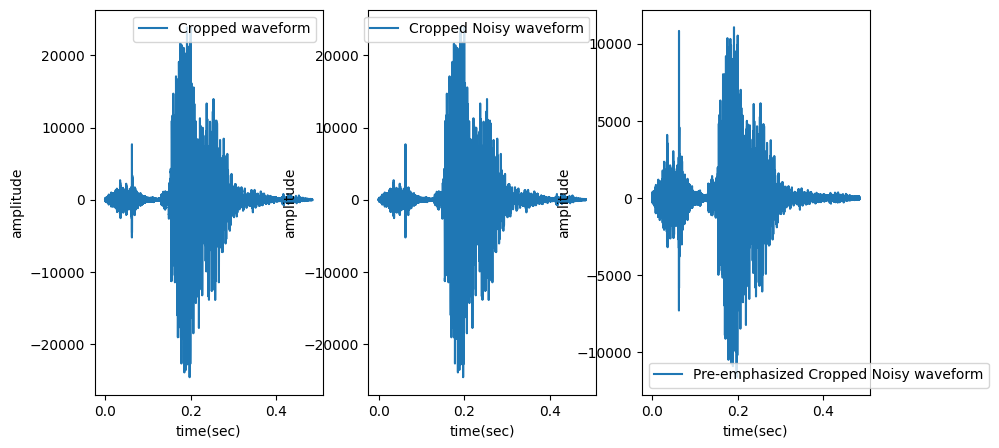

In [257]:
f_samp = commands_cropped[7][3][0] # [command][speaker][position in inner list]
sig = commands_cropped[7][3][1]
dur = commands_cropped[7][3][2]
print("Length of original signal",len(sig))
print("Duration of original signal",dur)

f_samp_cropped = commands_noisy_cropped[7][3][0] # [command][speaker][position in inner list]
sig_cropped = commands_noisy_cropped[7][3][1]
dur_cropped = commands_noisy_cropped[7][3][2]
print("Length of cropped signal",len(sig_cropped))
print("Duration of cropped signal",dur_cropped)

f_samp_cropped_pre = pre_emp_commands_noisy_cropped[7][3][0] # [command][speaker][position in inner list]
sig_cropped_pre = pre_emp_commands_noisy_cropped[7][3][1]
dur_cropped_pre = pre_emp_commands_noisy_cropped[7][3][2]
print("Length of cropped signal",len(sig_cropped_pre))
print("Duration of cropped signal",dur_cropped_pre)

plt.figure(figsize=(10,5))
#print("For the first file of the first command")
t = np.linspace(0,dur,len(sig))
plt.subplot(1,3,1)
plt.plot(t,sig,label="Cropped waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
        
t = np.linspace(0,dur_cropped,len(sig_cropped))
plt.subplot(1,3,2)
plt.plot(t,sig_cropped,label="Cropped Noisy waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()

t = np.linspace(0,dur_cropped_pre,len(sig_cropped_pre))
plt.subplot(1,3,3)
plt.plot(t,sig_cropped_pre,label="Pre-emphasized Cropped Noisy waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
#plt.title("For the first file of the first command")
plt.show()

In [258]:
Audio(sig,rate=f_samp)

In [259]:
Audio(sig_cropped,rate=f_samp_cropped)

In [260]:
Audio(sig_cropped_pre,rate=f_samp_cropped_pre)

#### MFCC Feature Extraction

In [261]:
mfcc_commands_noisy = []
for pre_emp_command_noisy_cropped in pre_emp_commands_noisy_cropped:
    mfcc_command_noisy = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(pre_emp_command_noisy_cropped)), desc="Loading..."):
        utterance = pre_emp_command_noisy_cropped[i]
        f_samp = utterance[0]
        sig = utterance[1]
        dur = utterance[2]
        frames,frame_length = framing(emphasized_signal=sig,sample_rate=f_samp)
        windowed_sig = windowing(frames,frame_length)
        pow_sig = fft_and_pow_spectrum(windowed_sig)
        mfb_sig = mel_filter_bank(pow_frames=pow_sig,sample_rate=f_samp)
        mfcc_sig = mfcc(mfb_sig)
        mfcc_command_noisy.append([f_samp,mfcc_sig,dur])
    mfcc_commands_noisy.append(mfcc_command_noisy)

Loading...: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 340.55it/s]


### Training

In [262]:
hmm_models_noisy = []
train_noisy_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\train_noisy'
for command_ind_noisy,mfcc_command_noisy in enumerate(mfcc_commands_noisy):
    #command_ind = mfcc_commands.index(mfcc_command)
    #print(command_ind)
    command_noisy = os.listdir(train_noisy_folder)[command_ind_noisy] # =label
    print(command_noisy)
    label = command_noisy
    #for utterance in command_cropped:
    X = np.array([])
    y_words = []
    for i in tqdm (range (len(mfcc_command_noisy)), desc="Loading..."):
        utterance = mfcc_command_noisy[i]
        f_samp = utterance[0]
        mfcc_features = utterance[1]
        #print(mfcc_features.shape)
        dur = utterance[2]
        if len(X) == 0:
            X = mfcc_features
        else:
            X = np.append(X, mfcc_features, axis=0)
        y_words.append(label)
    #print(len(y_words))
    print('X.shape =', X.shape)
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X)
    #print(hmm_trainer)
    hmm_models_noisy.append((hmm_trainer, label))
    hmm_trainer = None

down


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8467.35it/s]

X.shape = (6685, 12)


go


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6638.66it/s]

X.shape = (6133, 12)


left


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5206.24it/s]

X.shape = (6090, 12)


no


Loading...: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 10027.98it/s]


X.shape = (6276, 12)
off


Loading...: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 20447.05it/s]

X.shape = (6038, 12)


on


Loading...: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 12741.29it/s]

X.shape = (6755, 12)


right


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7050.20it/s]

X.shape = (6351, 12)


stop


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8613.60it/s]

X.shape = (6462, 12)


up


Loading...: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6564.06it/s]

X.shape = (5094, 12)


yes


Loading...: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 13218.73it/s]

X.shape = (6759, 12)


### Pre-processing test dataset

In [263]:
#Extracted folders
test_noisy_folder = r'C:\Users\Sanika Padegaonkar\Documents\Sanika_to_New_Laptop\Class Materials\EE679\Assignment3\Commands_Dataset_Extracted\test\test_noisy'
commands_noisy_test = []
for command_noisy in os.listdir(test_noisy_folder):
    command_noisy_folder = os.path.join(test_noisy_folder,command_noisy)
    command_noisy_test = []
    for filename in os.listdir(command_noisy_folder):
        file = os.path.join(command_noisy_folder,filename)
        f_samp, sig = wavfile.read(file)
        #print("The number of samples = ",len(sig))
        sig = sig.astype(float)
        dur = len(sig)/f_samp
        #print("The sampling frequency of the signal is = ",f_samp, "Hz")
        #print("The duration of the signal is:",dur, "seconds")
        command_noisy_test.append([f_samp,sig,dur])
    commands_noisy_test.append(command_noisy_test)

#### Speech End-pointing
---
1. Method 1: Amplitude-based. We will only keep samples which have an amplitude greater than 0.25% of the maximum amplitude of the signal and assume that the rest is silence.
2. Method 2: Speech Activity Detection (SAD)

##### 1. Amplitude/Energy based

In [264]:
commands_noisy_cropped_test = []
commands_noisy_voiced_ind_test = []
for command_noisy in commands_noisy_test:
    #print(command)
    command_noisy_cropped_test = []
    command_noisy_voiced_ind_test = []
    #for file in command:
    for i in tqdm (range (len(command_noisy)), desc="Loading..."): # Using only 100 utterances of each command due to lack of computational resources
        file = command_noisy[i]
        #print(file)
        f_samp = file[0]
        sig = file[1]
        dur = file[2]
        max_amp = np.max(sig)
        #print("Maximum Amplitude",max_amp)
        #print("Minimum absolute Amplitude",np.min(np.abs(sig)))
        #print(0.25*max_amp)
        sig_noisy_cropped = []
        #print(sig)
        noisy_voiced_indices_amp_test = []
        for samp in sig:
            #print(samp)
            if(np.abs(samp)>0.25/100*max_amp): # Only keep samples having amplitude > 0.25% of the max amplitude
                #print("Yes")
                sig_noisy_cropped.append(samp)
                noisy_voiced_indices_amp_test.append(list(sig).index(samp))
            #else:
                #print("No")
        sig_noisy_cropped = np.array(sig_noisy_cropped)
        #print(len(sig_cropped))
        dur_cropped = len(sig_noisy_cropped)/f_samp
        #print(dur_cropped)
        command_noisy_cropped_test.append([f_samp,sig_noisy_cropped,dur_cropped])
        command_noisy_voiced_ind_test.append(noisy_voiced_indices_amp_test)
    commands_noisy_cropped_test.append(command_noisy_cropped_test)
    commands_noisy_voiced_ind_test.append(command_noisy_voiced_ind_test)
        
        #plt.figure(figsize=(10,5))
        
        #ind1 = random.randint(0,len(commands))
        #ind2 = random.randint(0,len(com))
        #if(file == commands[0][0]):        

Loading...:  71%|██████████████████████████████████████████████▋                   | 176/249 [1:38:21<40:47, 33.53s/it]


KeyboardInterrupt: 

#### Comment
---
This method is not expected to work for noisy signals and hence can be omitted.

#### Pre-emphasis 

In [265]:
pre_emp_commands_noisy_test = []
for command_noisy_test in commands_noisy_test:
    pre_emp_command_noisy_test = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(command_noisy_test)), desc="Loading..."):
        utterance = command_noisy_test[i]
        f_samp = utterance[0]
        sig = utterance[1]
        dur = utterance[2]
        pre_emp_sig = pre_emphasis(sig)
        pre_emp_command_noisy_test.append([f_samp,pre_emp_sig,dur])
    pre_emp_commands_noisy_test.append(pre_emp_command_noisy_test)

Loading...: 100%|████████████████████████████████████████████████████████████████████| 256/256 [00:02<00:00, 86.47it/s]


Length of original signal 16000
Duration of original signal 1.0
Length of cropped signal 16000
Duration of cropped signal 1.0
Length of cropped signal 16000
Duration of cropped signal 1.0


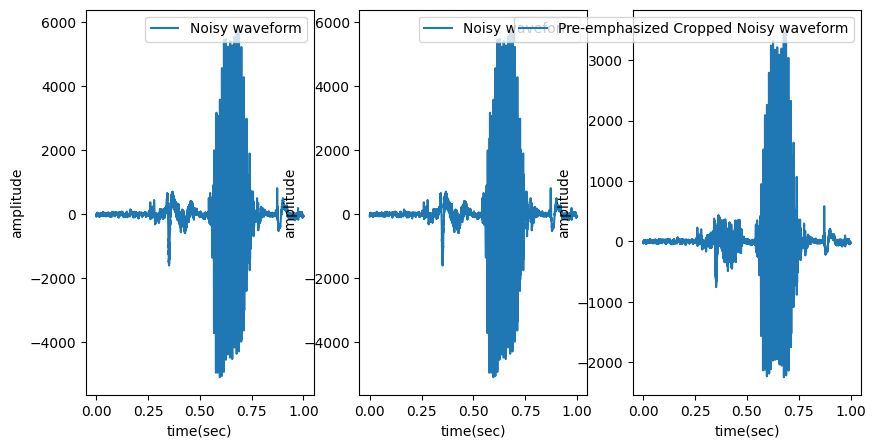

In [266]:
f_samp = commands_noisy_test[7][3][0] # [command][speaker][position in inner list]
sig_test = commands_noisy_test[7][3][1]
dur_test = commands_noisy_test[7][3][2]
print("Length of original signal",len(sig_test))
print("Duration of original signal",dur_test)

f_samp_cropped = commands_noisy_test[7][3][0] # [command][speaker][position in inner list]
sig_cropped_test = commands_noisy_test[7][3][1]
dur_cropped_test = commands_noisy_test[7][3][2]
print("Length of cropped signal",len(sig_cropped_test))
print("Duration of cropped signal",dur_cropped_test)

f_samp_cropped_pre = pre_emp_commands_noisy_test[7][3][0] # [command][speaker][position in inner list]
sig_cropped_pre_test = pre_emp_commands_noisy_test[7][3][1]
dur_cropped_pre_test = pre_emp_commands_noisy_test[7][3][2]
print("Length of cropped signal",len(sig_cropped_pre_test))
print("Duration of cropped signal",dur_cropped_pre_test)

plt.figure(figsize=(10,5))
#print("For the first file of the first command")
t = np.linspace(0,dur_test,len(sig_test))
plt.subplot(1,3,1)
plt.plot(t,sig_test,label="Noisy waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
        
t = np.linspace(0,dur_cropped_test,len(sig_cropped_test))
plt.subplot(1,3,2)
plt.plot(t,sig_cropped_test,label="Noisy waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()

t = np.linspace(0,dur_cropped_pre_test,len(sig_cropped_pre_test))
plt.subplot(1,3,3)
plt.plot(t,sig_cropped_pre_test,label="Pre-emphasized Cropped Noisy waveform")
plt.xlabel("time(sec)")
plt.ylabel("amplitude")
plt.legend()
#plt.title("For the first file of the first command")
plt.show()

In [267]:
Audio(sig_test,rate=f_samp)

In [268]:
Audio(sig_cropped_test,rate=f_samp_cropped)

In [269]:
Audio(sig_cropped_pre_test,rate=f_samp_cropped_pre)

#### MFCC Feature Extraction

In [270]:
mfcc_commands_noisy_test = []
for pre_emp_command_noisy_test in pre_emp_commands_noisy_test:
    mfcc_command_noisy_test = []
    #for utterance in command_cropped:
    for i in tqdm (range (len(pre_emp_command_noisy_test)), desc="Loading..."):
        utterance = pre_emp_command_noisy_test[i]
        f_samp = utterance[0]
        sig = utterance[1]
        dur = utterance[2]
        frames,frame_length = framing(emphasized_signal=sig,sample_rate=f_samp)
        windowed_sig = windowing(frames,frame_length)
        pow_sig = fft_and_pow_spectrum(windowed_sig)
        mfb_sig = mel_filter_bank(pow_frames=pow_sig,sample_rate=f_samp)
        mfcc_sig = mfcc(mfb_sig)
        mfcc_command_noisy_test.append([f_samp,mfcc_sig,dur])
    mfcc_commands_noisy_test.append(mfcc_command_noisy_test)

Loading...: 100%|███████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 262.11it/s]


### Testing

In [274]:
correct_noisy_commands = 0
num_noisy_files = 0
actual_noisy = []
predicted_noisy = []
for command_ind,mfcc_command_noisy_test in enumerate(mfcc_commands_noisy_test):
    #command_ind = mfcc_commands.index(mfcc_command)
    #print(command_ind)
    correct_noisy_command = 0
    actual_noisy_command = []
    predicted_noisy_command = []
    predicted_noisy_val = []
    command = os.listdir(train_noisy_folder)[command_ind] # =label
    print(command)
    #label = command
    #for utterance in command_cropped:
    X = np.array([])
    y_words = []
    for i in tqdm (range (len(mfcc_command_noisy_test)), desc="Loading..."):
    #for i in range(len(mfcc_command_noisy_test)):
        utterance = mfcc_command_noisy_test[i]
        f_samp = utterance[0]
        mfcc_features = utterance[1]
        #print(mfcc_features.shape)
        dur = utterance[2]
        #if len(X) == 0:
        #    X = mfcc_features
        #else:
        #    X = np.append(X, mfcc_features, axis=0)
        #y_words.append(label)
        scores_noisy=[]
        for item in hmm_models_noisy:
            hmm_model, label = item
            
            score = hmm_model.get_score(mfcc_features)
            scores_noisy.append(score)
        index=np.array(scores_noisy).argmax()
        #print("\nTrue:", command)
        #print("Predicted:", hmm_models[index][1]) 
        if(command == hmm_models_noisy[index][1]):
            correct_noisy_command+=1
            correct_noisy_commands+=1
            predicted_noisy_val.append(command)
        else:
            predicted_noisy_val.append('mismatch')
        num_noisy_files+=1
        actual_noisy_command.append(command)
        predicted_noisy_command.append(hmm_models_noisy[index][1])
        actual_noisy.append(command)
        predicted_noisy.append(hmm_models_noisy[index][1])
    #print(actual_command)
    #print(predicted_command)
    #compute the confusion matrix.
    #cm = confusion_matrix(actual_command,predicted_val)
    #cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [command,'mismatch'])
    #cm_display.plot()
    #plt.show()
    accuracy_noisy_command = correct_noisy_command/len(mfcc_command_noisy_test)
    print("Accuracy per command: ",accuracy_noisy_command)
accuracy_noisy = correct_noisy_commands/num_noisy_files
print("Overall Accuracy: ",accuracy_noisy)
    #print(len(y_words))
    #print('X.shape =', X.shape)
    #hmm_trainer = HMMTrainer()
    #hmm_trainer.train(X)
    #print(hmm_trainer)
    #hmm_models.append((hmm_trainer, label))
    #hmm_trainer = None

down


Loading...: 100%|███████████████████████████████████████████████████████████████████| 253/253 [00:01<00:00, 141.33it/s]


Accuracy per command:  0.1857707509881423
go


Loading...: 100%|███████████████████████████████████████████████████████████████████| 251/251 [00:01<00:00, 146.58it/s]


Accuracy per command:  0.4262948207171315
left


Loading...: 100%|███████████████████████████████████████████████████████████████████| 267/267 [00:01<00:00, 151.94it/s]


Accuracy per command:  0.5468164794007491
no


Loading...: 100%|███████████████████████████████████████████████████████████████████| 252/252 [00:01<00:00, 139.51it/s]


Accuracy per command:  0.3055555555555556
off


Loading...: 100%|███████████████████████████████████████████████████████████████████| 262/262 [00:01<00:00, 151.38it/s]


Accuracy per command:  0.5419847328244275
on


Loading...: 100%|███████████████████████████████████████████████████████████████████| 246/246 [00:01<00:00, 130.21it/s]


Accuracy per command:  0.22357723577235772
right


Loading...: 100%|███████████████████████████████████████████████████████████████████| 259/259 [00:01<00:00, 152.34it/s]


Accuracy per command:  0.6332046332046332
stop


Loading...: 100%|███████████████████████████████████████████████████████████████████| 249/249 [00:01<00:00, 144.28it/s]


Accuracy per command:  0.4538152610441767
up


Loading...: 100%|███████████████████████████████████████████████████████████████████| 272/272 [00:01<00:00, 146.03it/s]


Accuracy per command:  0.6323529411764706
yes


Loading...: 100%|███████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 152.88it/s]

Accuracy per command:  0.72265625
Overall Accuracy:  0.47058823529411764


### Plotting the confusion matrix

Overall Accuracy:  0.47058823529411764


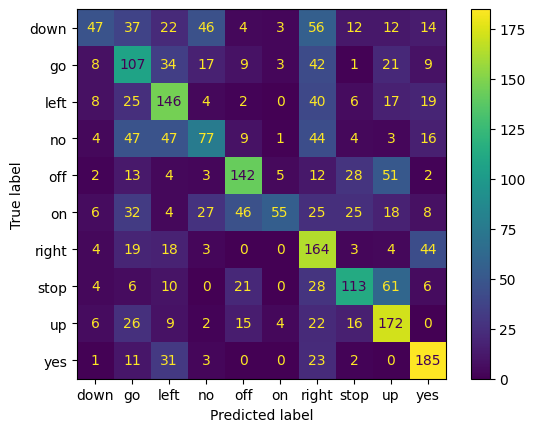

In [275]:
print("Overall Accuracy: ",accuracy_noisy)
#compute the confusion matrix.
cm_noisy = confusion_matrix(actual_noisy,predicted_noisy)
cm_noisy_display = ConfusionMatrixDisplay(confusion_matrix = cm_noisy, display_labels = os.listdir(test_noisy_folder))
cm_noisy_display.plot()

#### Comments
---
1. Overall accuracy is lower for noisy test inputs.